In [16]:
#Loading libraries
import pandas as pd 

import os
import re
import nltk
from sklearn import feature_extraction
from tqdm import tqdm


import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression

# NLTK
from nltk.tokenize import RegexpTokenizer
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import re

# Visualization
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib
%matplotlib inline
import seaborn as sns
from nltk.stem import WordNetLemmatizer

from gensim.models.word2vec import Word2Vec
from collections import Counter, defaultdict
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.cross_validation import StratifiedShuffleSplit

In [85]:
df_all = pd.read_csv('../preprocessed.csv')

### tfidf vectorizer

Using TF IDF vectorizer to turn into sparse matrices after preprocessing then convert the matrices into dataframes.  

In [18]:
tfidf_vector = TfidfVectorizer(min_df = 5, stop_words='english')

articleBody_matrix_sparse = tfidf_vector.fit_transform(df_all['articleBody'])
articleBody_matrix_sparse

<49972x18408 sparse matrix of type '<class 'numpy.float64'>'
	with 6480420 stored elements in Compressed Sparse Row format>

In [19]:
articleBody_df_tfdf = pd.DataFrame(articleBody_matrix_sparse.toarray(),
                                 index = df_all.index,
                                 columns = tfidf_vector.get_feature_names())

In [ ]:
articleBody_df_tfdf.head()

In [ ]:
headline_matrix_sparse = tfidf_vector.fit_transform(df_all['Headline'])
headline_matrix_sparse

In [ ]:
headline_df_tfdf = pd.DataFrame(headline_matrix_sparse.toarray(),
                                 index = df_all.index,
                                 columns = tfidf_vector.get_feature_names())

## Truncated SVD

We now need to  perform linear dimensionality reduction using singular value decomposition on the TF IDF matrices. We need the matrices in this form to calculate cosine similarity. 

In [23]:
from sklearn.decomposition import TruncatedSVD

In [24]:
n_components = 100
SVD = TruncatedSVD(n_components)
component_names = ["component_"+str(i) for i in range(n_components)]

In [27]:
articleBody_svd_matrix = SVD.fit_transform(articleBody_df_tfdf)
articleBody_svd_matrix

array([[ 3.25263349e-06, -1.25674778e-02, -4.13840461e-02, ...,
        -4.85546759e-02,  7.29410220e-02, -5.21077254e-02],
       [ 1.00000325e+00, -1.25693992e-02, -4.13982050e-02, ...,
        -4.85547853e-02,  7.29416732e-02, -5.21075052e-02],
       [ 2.00000325e+00, -1.25713206e-02, -4.14123639e-02, ...,
        -4.85548947e-02,  7.29423243e-02, -5.21072850e-02],
       ...,
       [ 8.68700000e+03, -6.56680842e-02, -1.40797969e-01, ...,
        -7.02939715e-03, -1.47037237e-02, -8.62375987e-03],
       [ 8.68800000e+03, -6.56700056e-02, -1.40812128e-01, ...,
        -7.02950655e-03, -1.47030726e-02, -8.62353967e-03],
       [ 8.68900000e+03, -6.56719270e-02, -1.40826287e-01, ...,
        -7.02961595e-03, -1.47024215e-02, -8.62331947e-03]])

In [26]:
headline_svd_matrix = SVD.fit_transform(headline_df_tfdf)
headline_svd_matrix

array([[ 2.33535793e-07, -6.85052484e-03, -3.91362592e-03, ...,
         1.10549429e-01, -6.25023135e-02, -1.30062919e-02],
       [ 1.00000046e+00, -5.87749680e-02, -2.19054775e-02, ...,
         2.06863429e-02,  2.40661332e-02,  1.37485621e-02],
       [ 2.00000026e+00, -5.88085452e-03, -7.64545394e-03, ...,
         6.27403834e-02, -4.41969824e-02, -4.73524991e-03],
       ...,
       [ 4.99690000e+04, -5.14170024e-02, -4.36050698e-02, ...,
         2.63796410e-02, -5.35207540e-02, -5.51653739e-02],
       [ 4.99700000e+04, -6.09749649e-02, -4.31805600e-02, ...,
         1.10528535e-02,  1.48272993e-02, -6.47606256e-03],
       [ 4.99710000e+04, -7.70971439e-02, -6.03772861e-02, ...,
        -6.00939288e-03, -7.98365170e-02, -1.34395887e-02]])

In [28]:
articleBody_svd_matrix.shape

(8690, 100)

## Cosine Similarity

Calculate distances between headline and articles to use as our X. 

In [29]:
import scipy.spatial as sp

In [30]:
distances = []
for i, body in enumerate(articleBody_svd_matrix): 
    distances.append(sp.distance.cdist([body], [headline_svd_matrix[i]], 'cosine')[0][0])

In [31]:
df_all['distances'] = pd.Series(distances)

In [32]:
df_all.shape

(49972, 6)

### Eliminating Nulls from all Data

In [33]:
df_all.shape

(49972, 6)

In [34]:
df_all = df_all.dropna(axis=0)

In [35]:
df_all.shape

(8690, 6)

In [36]:
df_all.head()

,Unnamed: 0,Headline,Body ID,Stance,articleBody,distances
0,0,police find mass graf least body near mexico ...,712,unrelated,danny boyle directing untitled film seth rogen...,1.019981
1,1,seth rogen play apple steve wozniak,712,discuss,danny boyle directing untitled film seth rogen...,0.463168
2,2,mexico police find mass grave near site stude...,712,unrelated,danny boyle directing untitled film seth rogen...,0.122537
3,3,mexico say missing student found first mass graf,712,unrelated,danny boyle directing untitled film seth rogen...,0.074741
4,4,new io bug delete icloud document,712,unrelated,danny boyle directing untitled film seth rogen...,0.045600


### Adding labels to stances

In [86]:
from sklearn import preprocessing

In [87]:
le = preprocessing.LabelEncoder()
le.fit(df_all['Stance'])
print("Classes:", list(le.classes_))
stance_label = le.transform(df_all['Stance']) 


Classes: ['agree', 'disagree', 'discuss', 'unrelated']


In [88]:
stance_label

array([3, 2, 3, ..., 0, 2, 2])

Creating dummies for the four stances. 

In [89]:
df_all['stance_dummy'] = pd.Series(stance_label)


In [91]:
df_all.to_csv('./preprocessed.csv')
df_all.head()

,Unnamed: 0,Headline,Body ID,Stance,articleBody,stance_dummy
0,0,police find mass graf least body near mexico ...,712,unrelated,danny boyle directing untitled film seth rogen...,3
1,1,seth rogen play apple steve wozniak,712,discuss,danny boyle directing untitled film seth rogen...,2
2,2,mexico police find mass grave near site stude...,712,unrelated,danny boyle directing untitled film seth rogen...,3
3,3,mexico say missing student found first mass graf,712,unrelated,danny boyle directing untitled film seth rogen...,3
4,4,new io bug delete icloud document,712,unrelated,danny boyle directing untitled film seth rogen...,3


In [42]:
stance_dummy = pd.get_dummies(df_all['Stance'], drop_first=False)
stance_dummy.head()

,agree,disagree,discuss,unrelated
0,0,0,0,1
1,0,0,1,0
2,0,0,0,1
3,0,0,0,1
4,0,0,0,1


Join both distances and stance dummy in one data frame for easy access and drop nulls if any. 

In [43]:
df_fix = pd.DataFrame([df_all['distances'], df_all['stance_dummy']]).T
df_fix = df_fix.dropna(axis=0)
df_fix.head()

,distances,stance_dummy
0,1.019981,3.0
1,0.463168,2.0
2,0.122537,3.0
3,0.074741,3.0
4,0.045600,3.0


In [44]:
df_fix.shape

(8690, 2)

## Model with Distance

In [45]:
from sklearn.model_selection import train_test_split

In [46]:
X = df_fix['distances'].values.reshape(df_fix['distances'].shape[0], 1)
y = df_fix['stance_dummy']

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [47]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((6517, 1), (2173, 1), (6517,), (2173,))

In [48]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
lr.score(X_train, y_train)

0.8421052631578947

In [49]:
lr.score(X_test, y_test)

0.8315692590888173

In [50]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(max_depth=25)
rf.fit(X_train, y_train)
rf.score(X_train, y_train)

0.8439466011968697

In [51]:
rf.score(X_test, y_test)

0.8292682926829268

After calculating cosine similarity between the headline and article body matrices the logistic regression model performed at 0.73156 compared to our baseline of 0.73171. Random forest scored very well but I found it was very overfit after scoring on the test. 
    

## Reciever Operating Characteristic (ROC) Curve

In [52]:
from sklearn.metrics import roc_auc_score

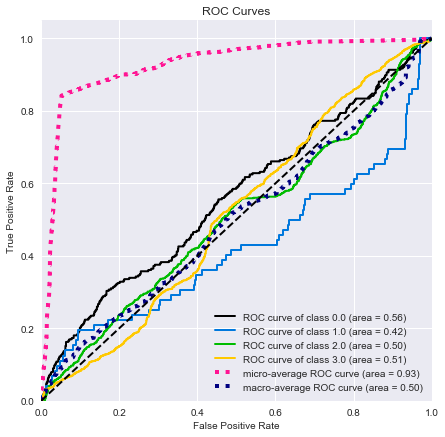

In [53]:
y_probas = lr.predict_proba(X_train)
y_true = y_train

import scikitplot as skplt
import matplotlib.pyplot as plt

skplt.metrics.plot_roc(y_true, y_probas, figsize=(7,7))
plt.show()

In [54]:
y_true.unique(), y_true.shape

(array([3., 2., 0., 1.]), (6517,))

The curve plots the diagnostic ability for the classifier system. The ROC curve plots the sensitivity against the false positive rate at various thresholds. A macro average will give us a score for each class then take the average. A mirco average will aggregate the contributoins of each class to give the average metric. The micro average shows us there is still a possibility for us to reach this number!

## Over Sampling 

#Trying to adjust the class distribution. 

In [55]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_sample(X, y)
from collections import Counter
print(sorted(Counter(y_resampled).items()))

lr = LogisticRegression()
lr.fit(X_resampled, y_resampled)
lr.score(X_resampled, y_resampled)

[(0.0, 7295), (1.0, 7295), (2.0, 7295), (3.0, 7295)]


0.25246744345442085

# Model with count vectorized body, count vectorized head, and distances

I count vectorize both headline and body.

In [56]:
cvec_vector = CountVectorizer(stop_words='english')
cvec_articleBody_matrix_sparse = cvec_vector.fit_transform(df_all['articleBody'])
cvec_articleBody_matrix_sparse

<8690x6841 sparse matrix of type '<class 'numpy.int64'>'
	with 1101010 stored elements in Compressed Sparse Row format>

In [57]:
cvec_body_array = cvec_articleBody_matrix_sparse.toarray()

In [58]:
df_cvec = pd.DataFrame(cvec_body_array)

In [59]:
df_cvec.head()

,0,1,2,3,4,5,6,7,8,9,...,6831,6832,6833,6834,6835,6836,6837,6838,6839,6840
0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [60]:
cvec_vector = CountVectorizer(stop_words='english')
cvec_headline_matrix_sparse = cvec_vector.fit_transform(df_all['Headline'])
cvec_headline_matrix_sparse

<8690x2607 sparse matrix of type '<class 'numpy.int64'>'
	with 68013 stored elements in Compressed Sparse Row format>

In [61]:
cvec_vector.get_feature_names

<bound method CountVectorizer.get_feature_names of CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words='english',
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)>

In [62]:
cvec_headline_df = pd.DataFrame(cvec_headline_matrix_sparse.todense(),
                       columns = cvec_vector.get_feature_names())

In [63]:
cvec_headline_df.shape

(8690, 2607)

In [64]:
cvec_vector = CountVectorizer(stop_words='english')

cvec_articlebody_matrix_sparse = cvec_vector.fit_transform(df_all['articleBody'])

cvec_articlebody_matrix_sparse

<8690x6841 sparse matrix of type '<class 'numpy.int64'>'
	with 1101010 stored elements in Compressed Sparse Row format>

In [65]:
cvec_articlebody_df = pd.DataFrame(cvec_articlebody_matrix_sparse.todense(),
                       columns = cvec_vector.get_feature_names())

In [66]:
df_fix.shape

(8690, 2)

Combine both vectorized headline, body, and distances into a dataframe.

In [67]:
df_headline_fix = pd.concat([df_fix, cvec_headline_df, cvec_articlebody_df], axis=1)

In [68]:
df_headline_fix.fillna(value=0, inplace=True)

In [69]:
features = [col for col in df_headline_fix.columns if col != 'stance_dummy']

Run both logistic regression and random forest classifier.

In [74]:
# Set x, y, and train, test split
X = df_headline_fix[features]
y = df_headline_fix['stance_dummy']

X_train, X_test, y_train, y_test = train_test_split(X, y)
#try to split further 

In [75]:
lr = LogisticRegression(penalty='l2',C=.1).fit(X_train.iloc[0:1000],
y_train.iloc[0:1000])
lr.fit(X_train, y_train)
lr.score(X_train, y_train)

0.9004143010587694

In [76]:
lr.score(X_test, y_test)

0.8716060745513116

In [77]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(max_depth=25)
rf.fit(X_train, y_train)
rf.score(X_train, y_train)

0.9117692189657818

In [78]:
rf.score(X_test, y_test)

0.8909341923607915

I combine the count vectorized headline and article body with the cosine similarity distances as the X and use stance dummy as the Y. I was hoping this would yeild a better result but logistic regression gave us a score of 0.73084 compared to the baseline of 0.73171. Random forest classifier results in a score of 0.95722 later to find it has overfit the model. 